# Ejercicios ensembling
En este ejercicio vas a realizar prediciones sobre un dataset de ciudadanos indios diabéticos. Se trata de un problema de clasificación en el que intentaremos predecir 1 (diabético) 0 (no diabético).

### 1. Carga las librerias que consideres comunes al notebook

In [2]:
# ===== IMPORTACIÓN DE LIBRERÍAS BÁSICAS =====
# Vamos a importar todas las librerías que necesitaremos a lo largo del notebook

# NumPy: para operaciones matemáticas y trabajo con arrays
import numpy as np

# Pandas: para manipulación y análisis de datos estructurados (DataFrames)
import pandas as pd

# Matplotlib: para crear visualizaciones básicas
import matplotlib.pyplot as plt

# Seaborn: para visualizaciones estadísticas más avanzadas y atractivas
import seaborn as sns

# Scikit-learn - Herramientas de validación y partición de datos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Scikit-learn - Métricas para evaluar nuestros modelos de clasificación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

### 2. Lee los datos de [esta direccion](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv)
Los nombres de columnas son:
```Python
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
```

In [3]:
# ===== CARGA DE DATOS =====
# Definimos la URL donde se encuentran los datos del dataset Pima Indians Diabetes
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# Leemos el CSV usando pandas
# Importante: este CSV no tiene encabezados, por eso usamos el parámetro 'names'
# preg: número de embarazos
# plas: concentración de glucosa en plasma
# pres: presión arterial diastólica (mm Hg)
# skin: grosor del pliegue cutáneo del tríceps (mm)
# test: insulina sérica de 2 horas (mu U/ml)
# mass: índice de masa corporal (peso en kg/(altura en m)^2)
# pedi: función de pedigree de diabetes (historial familiar)
# age: edad en años
# class: variable objetivo (1=diabético, 0=no diabético)
df = pd.read_csv(url, names=['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'])

# Mostramos las primeras 5 filas para ver cómo son nuestros datos
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# ===== EXPLORACIÓN: INFORMACIÓN DEL DATASET =====
# .info() nos da un resumen muy útil:
# - Número total de registros (768 pacientes)
# - Tipos de datos de cada columna
# - Si hay valores nulos (non-null count)
# - Uso de memoria
# Vemos que tenemos 768 registros sin valores nulos, lo cual es excelente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# ===== EXPLORACIÓN: ESTADÍSTICAS DESCRIPTIVAS =====
# .describe() calcula estadísticas resumen para cada variable numérica:
# - count: número de valores
# - mean: media aritmética
# - std: desviación estándar (dispersión de los datos)
# - min, 25%, 50%, 75%, max: percentiles que nos ayudan a entender la distribución

# Observaciones importantes:
# - La variable 'class' tiene media 0.35, lo que indica que ~35% son diabéticos (dataset desbalanceado)
# - Algunas variables tienen valores mínimos de 0 que podrían ser valores faltantes (ej: presión arterial=0 no es posible)
df.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


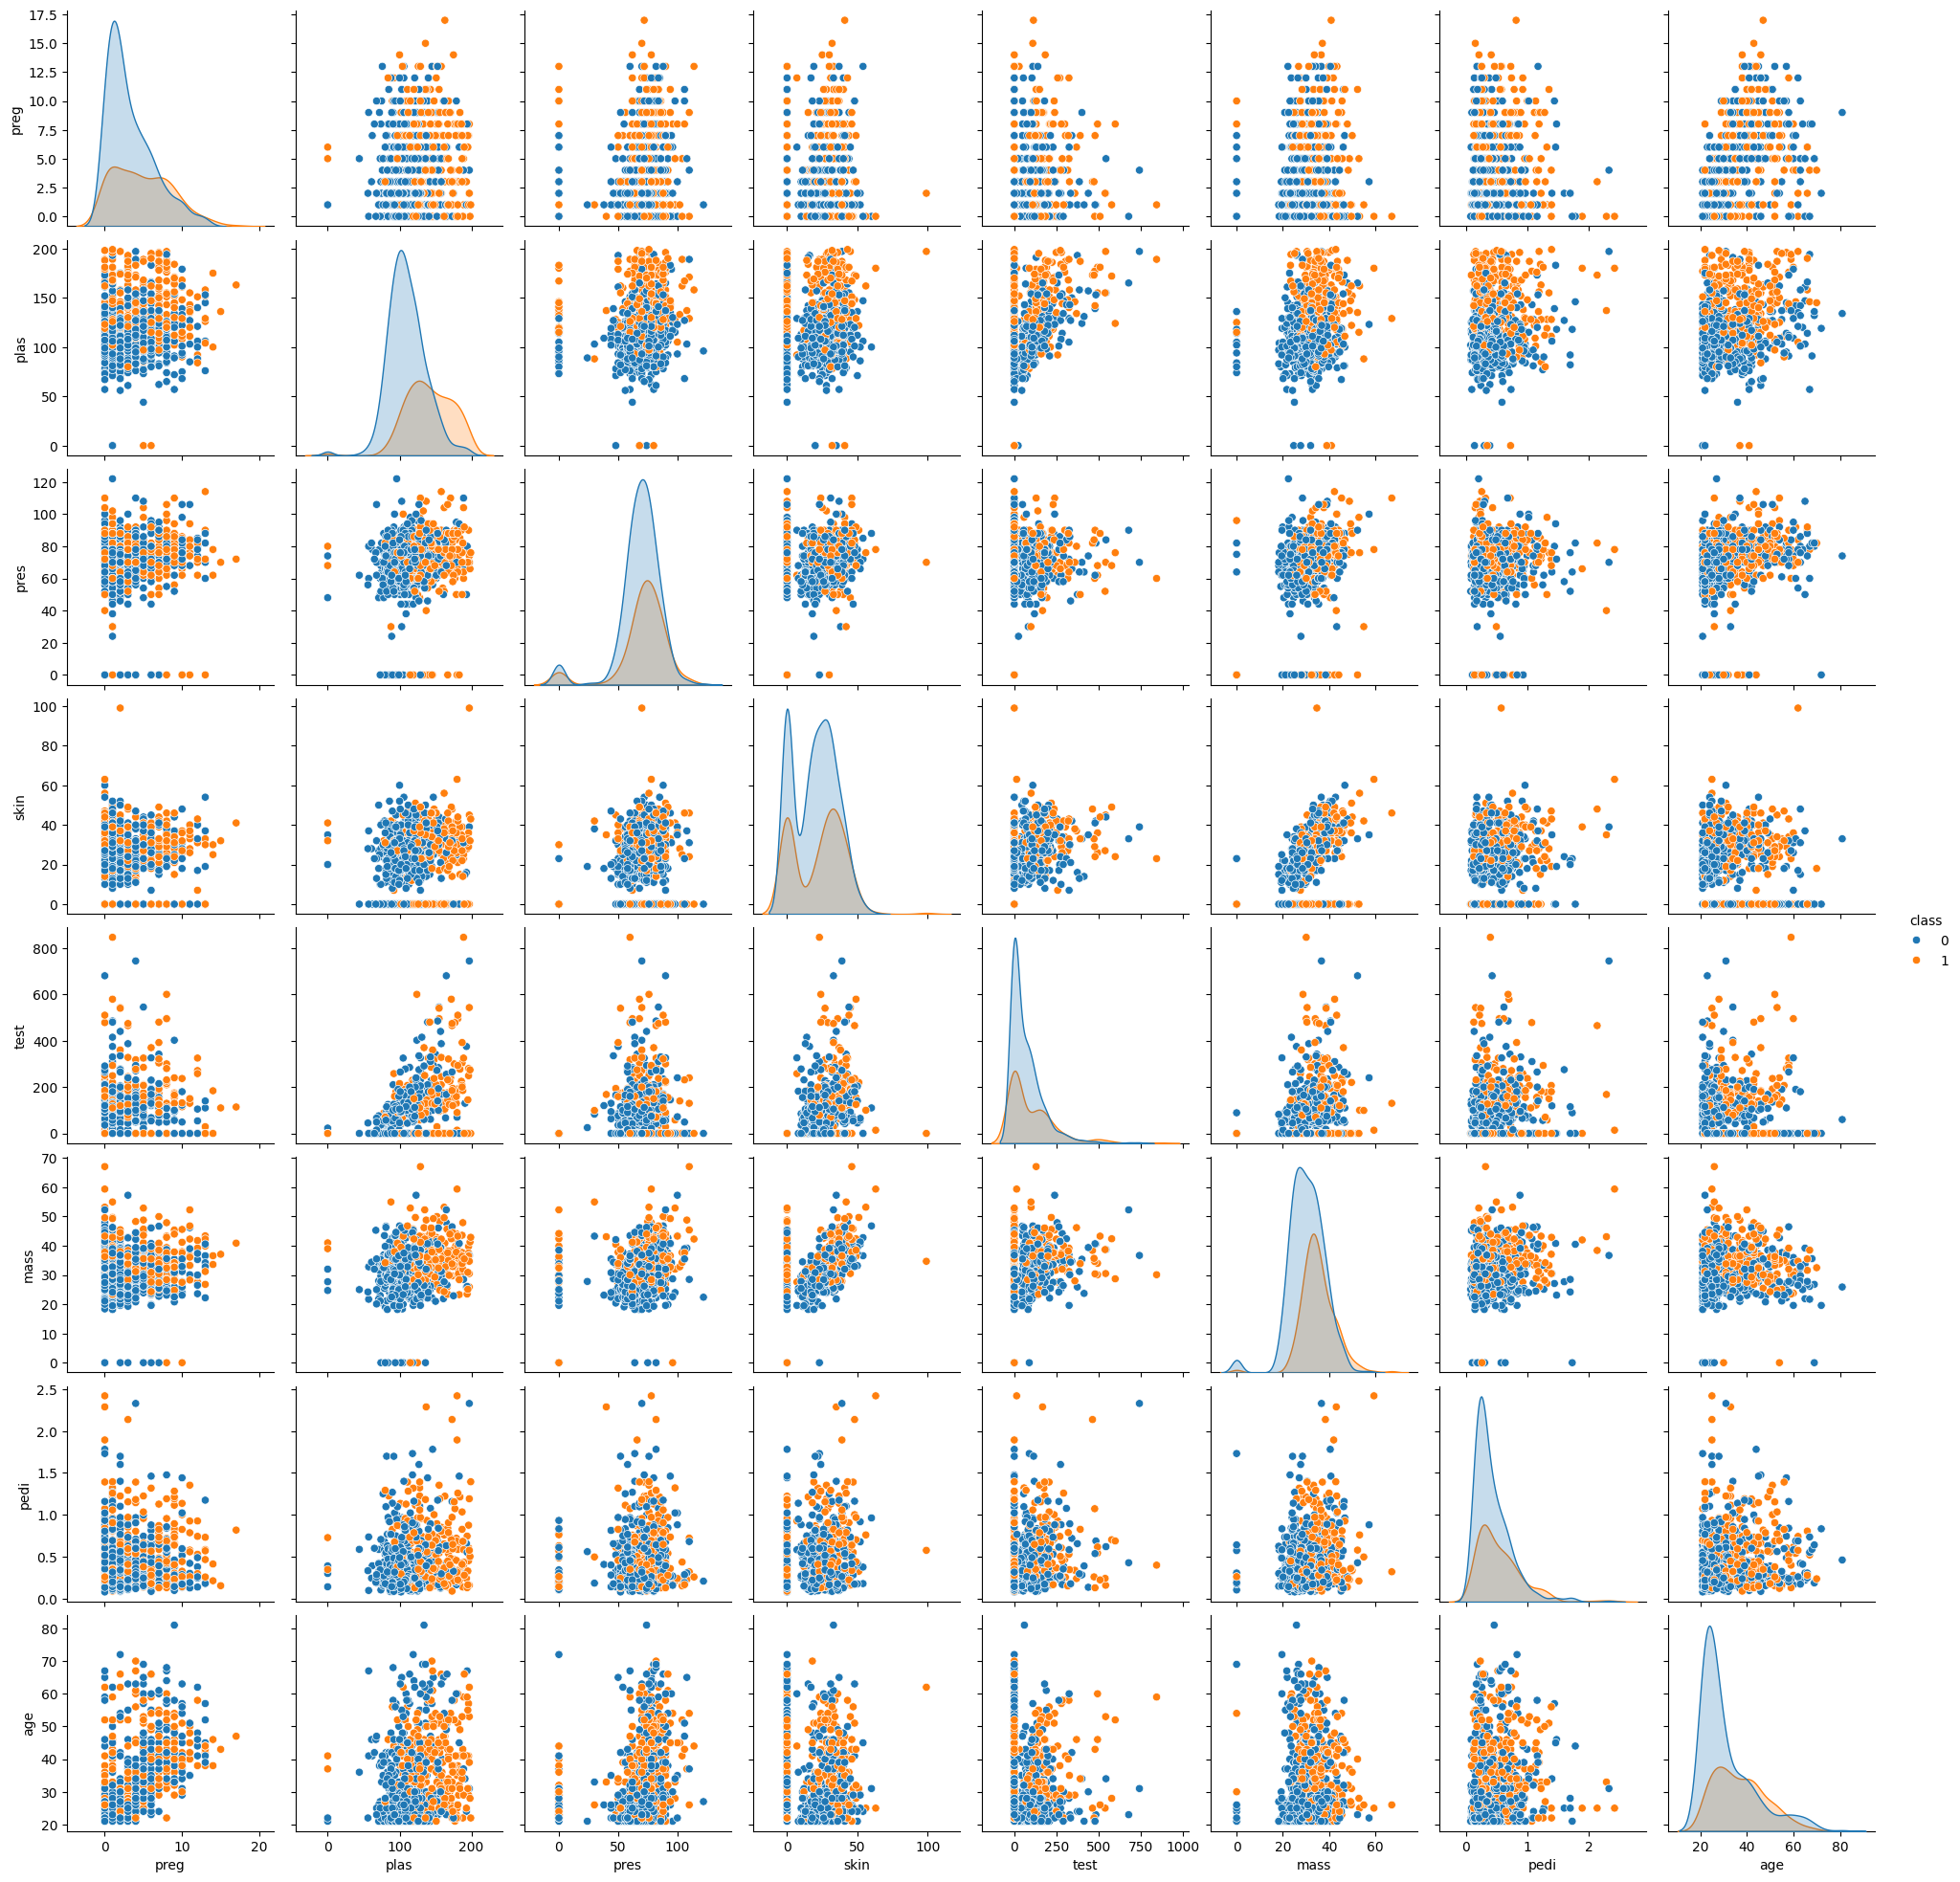

In [6]:
# ===== VISUALIZACIÓN: PAIRPLOT =====
# El pairplot crea una matriz de gráficos que muestra:
# - En la diagonal: distribución de cada variable (histograma/densidad)
# - Fuera de la diagonal: relación entre pares de variables (scatter plots)
# 
# El parámetro hue='class' colorea los puntos según si son diabéticos (1) o no (0)
# Esto nos ayuda a identificar visualmente qué variables separan mejor las clases
# 
# ¿Qué buscamos?
# - Variables donde los dos colores estén bien separados → buenos predictores
# - Patrones, tendencias o agrupaciones en los datos
sns.pairplot(df, hue="class")

<Axes: >

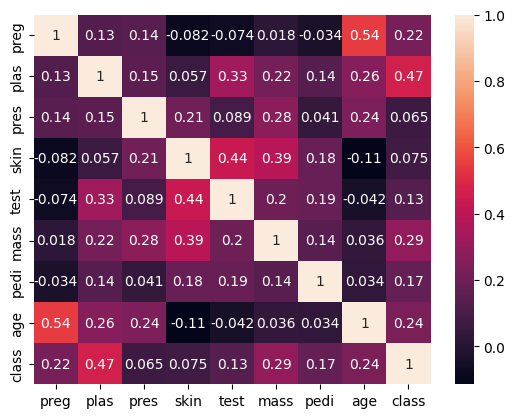

In [7]:
# ===== VISUALIZACIÓN: MATRIZ DE CORRELACIÓN =====
# El heatmap de correlación nos muestra las relaciones lineales entre variables
# 
# Interpretación:
# - Valores cercanos a 1: correlación positiva fuerte (cuando una sube, la otra también)
# - Valores cercanos a -1: correlación negativa fuerte (cuando una sube, la otra baja)
# - Valores cercanos a 0: no hay correlación lineal
# 
# annot=True muestra los valores numéricos en cada celda
# 
# Nos interesa especialmente la última fila/columna (correlación con 'class')
# para identificar qué variables están más relacionadas con ser diabético
sns.heatmap(df.corr(), annot=True)
#sns.heatmap(df.corr(), annot=True,cmap='coolwarm' , vmin=-1) 

In [8]:
# ===== ANÁLISIS DEL DESBALANCEO DE CLASES =====
# Calculamos la proporción de cada clase en el dataset
# normalize=True nos da porcentajes en lugar de conteos absolutos
# 
# Resultado: 
# - 65% no diabéticos (clase 0)
# - 35% diabéticos (clase 1)
# 
# Esto es importante porque tenemos un desbalanceo moderado
# Los modelos podrían tener sesgo hacia predecir la clase mayoritaria
# Deberíamos considerar métricas como recall, precision y ROC-AUC, no solo accuracy
df['class'].value_counts(normalize=True)

class
0    0.651042
1    0.348958
Name: proportion, dtype: float64

al tener desvalanceo usamos tecnicas como oversampling y undersampling(buscar en google)

### 3. Bagging
Para este apartado tendrás que crear un ensemble utilizando la técnica de bagging ([BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)), mediante la cual combinarás 100 [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Recuerda utilizar también [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) con 10 kfolds.

**Para este apartado y siguientes, no hace falta que dividas en train/test**, por hacerlo más sencillo. Simplemente divide tus datos en features y target.

Establece una semilla

In [9]:
# ===== PREPARACIÓN DE DATOS PARA MODELADO =====
# Separamos nuestros datos en:
# 
# X (features/características): todas las columnas excepto 'class'
# - Son las variables que usaremos para hacer predicciones
# - En este caso: preg, plas, pres, skin, test, mass, pedi, age
X = df.drop(columns=['class'])

# y (target/objetivo): la columna 'class' que queremos predecir
# - 1 = diabético
# - 0 = no diabético
y = df['class']

# Establecemos una semilla (seed) para reproducibilidad
# Esto garantiza que los números aleatorios sean siempre los mismos
# y podamos replicar exactamente los resultados
seed = 42

In [10]:
# ===== IMPORTACIÓN DE MODELOS PARA BAGGING =====
# Importamos las herramientas necesarias para crear nuestro primer ensemble

# DecisionTreeClassifier: árbol de decisión (modelo base que vamos a ensamblar)
from sklearn.tree import DecisionTreeClassifier

# BaggingClassifier: implementa la técnica de Bootstrap Aggregating
# Crea múltiples modelos entrenados con diferentes muestras de los datos
from sklearn.ensemble import BaggingClassifier

# KFold: para realizar validación cruzada dividiendo los datos en K particiones
from sklearn.model_selection import KFold

In [11]:
# ===== CONFIGURACIÓN DEL MODELO BAGGING =====

# 1. Creamos el modelo base: un árbol de decisión con profundidad máxima de 5
# max_depth=5 limita la profundidad del árbol para evitar overfitting
dtc = DecisionTreeClassifier(max_depth=5)

# 2. Creamos el ensemble de Bagging
# - estimator=dtc: usamos árboles de decisión como modelos base
# - n_estimators=100: crearemos 100 árboles diferentes
# - random_state=seed: para reproducibilidad
# 
# ¿Cómo funciona Bagging?
# - Toma 100 muestras bootstrap (con reemplazo) de los datos originales
# - Entrena un árbol en cada muestra
# - Para predecir, hace votación por mayoría entre los 100 árboles
bc = BaggingClassifier(estimator=dtc, n_estimators=100, random_state=seed)

# 3. Configuramos la validación cruzada con 10 particiones (folds)
# Dividirá los datos en 10 partes: 9 para entrenar, 1 para validar
# Se repite 10 veces usando cada partición como validación una vez
kf = KFold(10)

In [12]:
# ===== VERIFICACIÓN DE LOS FOLDS DE VALIDACIÓN CRUZADA =====
# Este código nos muestra cómo KFold divide nuestros datos

# Iteramos sobre cada uno de los 10 folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    # train_index: índices de las filas que se usan para entrenar
    # test_index: índices de las filas que se usan para validar
    
    # Mostramos el rango de índices del conjunto de test en cada fold
    # Esto nos ayuda a verificar que los datos se dividen correctamente
    # y que cada fold usa aproximadamente 1/10 de los datos para test
    print(f"Test: index={test_index.min()}")
    print(f"Test: index={test_index.max()}")

Fold 0:
Test: index=0
Test: index=76
Fold 1:
Test: index=77
Test: index=153
Fold 2:
Test: index=154
Test: index=230
Fold 3:
Test: index=231
Test: index=307
Fold 4:
Test: index=308
Test: index=384
Fold 5:
Test: index=385
Test: index=461
Fold 6:
Test: index=462
Test: index=538
Fold 7:
Test: index=539
Test: index=615
Fold 8:
Test: index=616
Test: index=691
Fold 9:
Test: index=692
Test: index=767


In [13]:
# ===== EVALUACIÓN DEL MODELO BAGGING CON VALIDACIÓN CRUZADA =====

# cross_val_score realiza automáticamente:
# 1. Divide los datos en 10 folds (según kf)
# 2. Para cada fold: entrena en 9 partes y valida en 1
# 3. Calcula la métrica especificada (accuracy) en cada fold
# 4. Devuelve un array con los 10 scores

bc_cv = cross_val_score(bc, X, y, cv=kf, scoring="accuracy")

# Mostramos los resultados
print(bc_cv)              # Accuracy en cada uno de los 10 folds
print(bc_cv.mean())       # Promedio: rendimiento general del modelo (~76.9%)
print(bc_cv.std())        # Desviación estándar: variabilidad del modelo (~6.9%)

# Un std bajo indica que el modelo es estable entre diferentes particiones de datos

[0.7012987  0.81818182 0.7012987  0.64935065 0.77922078 0.85714286
 0.83116883 0.85714286 0.72368421 0.77631579]
0.7694805194805194
0.06893057161455383


### 4. Random Forest
En este caso entrena un [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) con 100 árboles y un `max_features` de 3. También con validación cruzada

In [14]:
# ===== IMPORTACIÓN DEL RANDOM FOREST =====
# Random Forest es una mejora sobre Bagging que añade aleatoriedad adicional
# No solo usa muestras bootstrap de datos, sino también subconjuntos aleatorios de features
from sklearn.ensemble import RandomForestClassifier

In [15]:
# ===== ENTRENAMIENTO Y EVALUACIÓN DE RANDOM FOREST =====

# Creamos el modelo Random Forest
# - n_estimators=100: construimos 100 árboles de decisión
# - max_features=3: cada árbol solo considera 3 features aleatorias en cada split
#   (de las 8 disponibles). Esto aumenta la diversidad entre árboles
# - max_depth=5: profundidad máxima de cada árbol (evita overfitting)
# - random_state=seed: para reproducibilidad
#
# Diferencia clave con Bagging:
# - Bagging: usa TODAS las features en cada split
# - Random Forest: usa solo un SUBCONJUNTO aleatorio de features
#   Esto reduce la correlación entre árboles y mejora la generalización
rfc = RandomForestClassifier(n_estimators=100, max_features=3, max_depth=5, random_state=seed)

# Evaluamos con validación cruzada (igual que con Bagging)
rfc_cv = cross_val_score(rfc, X, y, cv=kf, scoring="accuracy")

# Mostramos resultados
print(rfc_cv)           # Accuracy en cada fold
print(rfc_cv.mean())    # Media: ~76.8% (similar a Bagging)
print(rfc_cv.std())     # Desviación estándar: ~6.5%

[0.71428571 0.83116883 0.74025974 0.64935065 0.75324675 0.81818182
 0.81818182 0.87012987 0.69736842 0.78947368]
0.7681647300068353
0.06546524440800212


### 5. AdaBoost
Implementa un [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) con 30 árboles.

In [16]:
# ===== IMPORTACIÓN DE ADABOOST =====
# AdaBoost es un algoritmo de Boosting (diferente a Bagging)
# En lugar de entrenar modelos en paralelo, los entrena secuencialmente
# Cada nuevo modelo se enfoca en corregir los errores del anterior
from sklearn.ensemble import AdaBoostClassifier

In [17]:
# ===== ENTRENAMIENTO Y EVALUACIÓN DE ADABOOST =====

# Creamos el modelo AdaBoost
# - n_estimators=30: usamos solo 30 árboles (menos que en Bagging/RF)
#   En Boosting, suelen necesitarse menos estimadores porque son secuenciales
# - random_state=seed: para reproducibilidad
#
# ¿Cómo funciona AdaBoost?
# 1. Entrena un modelo débil en los datos originales
# 2. Identifica las observaciones mal clasificadas
# 3. Aumenta el peso de esas observaciones difíciles
# 4. Entrena un nuevo modelo que se enfoca más en esos casos difíciles
# 5. Repite el proceso n_estimators veces
# 6. La predicción final es un voto ponderado de todos los modelos
#
# Diferencia con Bagging/RF:
# - Bagging/RF: modelos independientes en paralelo
# - AdaBoost: modelos dependientes en secuencia, cada uno mejora al anterior
abc = AdaBoostClassifier(n_estimators=30, random_state=seed)

# Evaluamos con validación cruzada
abc_cv = cross_val_score(abc, X, y, cv=kf, scoring="accuracy")

# Mostramos resultados
print(abc_cv)           # Accuracy en cada fold
print(abc_cv.mean())    # Media: ~76.6%
print(abc_cv.std())     # Desviación estándar: ~5.7%

[0.68831169 0.84415584 0.75324675 0.66233766 0.76623377 0.80519481
 0.77922078 0.83116883 0.72368421 0.80263158]
0.7656185919343814
0.056693414216223405


### 6. GradientBoosting
Implementa un [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) con 100 estimadores

In [18]:
# ===== IMPORTACIÓN DE GRADIENT BOOSTING =====
# Gradient Boosting es otra técnica de Boosting más sofisticada que AdaBoost
# En lugar de ajustar pesos, entrena cada modelo para predecir los errores (residuos) del anterior
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
# ===== ENTRENAMIENTO Y EVALUACIÓN DE GRADIENT BOOSTING =====

# Creamos el modelo Gradient Boosting
# - n_estimators=100: construimos 100 árboles secuenciales
# - random_state=seed: para reproducibilidad
#
# ¿Cómo funciona Gradient Boosting?
# 1. Entrena un primer modelo que hace predicciones iniciales
# 2. Calcula los residuos (diferencia entre predicción y valor real)
# 3. Entrena un nuevo modelo para predecir esos residuos
# 4. Suma la predicción del nuevo modelo a las anteriores
# 5. Repite el proceso, cada modelo aprende de los errores acumulados
# 6. La predicción final es la suma de todos los modelos
#
# Ventajas sobre AdaBoost:
# - Más flexible y generalizable
# - Mejor manejo de diferentes tipos de problemas
# - Suele dar mejores resultados en la práctica
gbc = GradientBoostingClassifier(n_estimators=100, random_state=seed)

# Evaluamos con validación cruzada
gbc_cv = cross_val_score(gbc, X, y, cv=kf, scoring="accuracy")

# Mostramos resultados
print(gbc_cv)           # Accuracy en cada fold
print(gbc_cv.mean())    # Media: ~76.6%
print(gbc_cv.std())     # Desviación estándar: ~5.8%

[0.71428571 0.83116883 0.74025974 0.63636364 0.79220779 0.79220779
 0.80519481 0.83116883 0.72368421 0.78947368]
0.7656015037593986
0.058212068854189405


### 7. XGBoost
Para este apartado utiliza un [XGBoostClassifier](https://docs.getml.com/latest/api/getml.predictors.XGBoostClassifier.html) con 100 estimadores. XGBoost no forma parte de la suite de modelos de sklearn, por lo que tendrás que instalarlo con pip install

In [20]:
# ===== ENTRENAMIENTO Y EVALUACIÓN DE XGBOOST =====

# XGBoost (eXtreme Gradient Boosting) es una implementación optimizada de Gradient Boosting
# Es una librería externa, no viene con sklearn (hay que instalarla: pip install xgboost)
from xgboost import XGBClassifier

# Creamos el modelo XGBoost
# - n_estimators=100: 100 árboles secuenciales
# - random_state=seed: reproducibilidad
#
# ¿Por qué XGBoost es especial?
# - Implementación MUCHO más rápida que GradientBoostingClassifier de sklearn
# - Manejo automático de valores faltantes
# - Regularización incorporada (previene overfitting)
# - Paralelización eficiente
# - Ha ganado numerosas competiciones de Kaggle
# - Incluye optimizaciones matemáticas y de software avanzadas
xgbc = XGBClassifier(n_estimators = 100, random_state=seed)

# Evaluamos con validación cruzada
xgbc_cv = cross_val_score(xgbc, X, y, cv=kf, scoring="accuracy")

# Mostramos resultados
print(xgbc_cv)          # Accuracy en cada fold
print(xgbc_cv.mean())   # Media: ~74.3% (curiosamente, peor que los anteriores en este caso)
print(xgbc_cv.std())    # Desviación estándar: ~3.2% (más estable que otros modelos)

[0.7012987  0.76623377 0.74025974 0.68831169 0.76623377 0.74025974
 0.77922078 0.79220779 0.72368421 0.73684211]
0.7434552289815447
0.03157014776658903


### 8. Primeros resultados
Crea un dataframe con los resultados y sus algoritmos, ordenándolos de mayor a menor

In [21]:
# ===== COMPARACIÓN DE RESULTADOS DE TODOS LOS MODELOS =====

# Creamos un DataFrame que resume los resultados de validación cruzada
# Esto nos permite comparar fácilmente el rendimiento de los 5 modelos

results_cv = pd.DataFrame({
    "cv_mean_acc": [
        bc_cv.mean(),    # Bagging Classifier
        rfc_cv.mean(),   # Random Forest
        abc_cv.mean(),   # AdaBoost
        gbc_cv.mean(),   # Gradient Boosting
        xgbc_cv.mean()   # XGBoost
    ]
}, index=["Bag", "RF", "AB", "GB", "XGB"])

# Mostramos la tabla comparativa
# Observamos que:
# - Bagging tiene el mejor rendimiento (~76.9%)
# - Random Forest muy cerca (~76.8%)
# - AdaBoost y Gradient Boosting muy similares (~76.6%)
# - XGBoost tiene el peor rendimiento (~74.3%) - posiblemente necesita más tuning
results_cv

,cv_mean_acc
Bag,0.769481
RF,0.768165
AB,0.765619
GB,0.765602
XGB,0.743455


### 9. Hiperparametrización
Vuelve a entrenar los modelos de nuevo, pero esta vez dividiendo el conjunto de datos en train/test y utilizando un gridsearch para encontrar los mejores hiperparámetros.

In [22]:
# ===== DIVISIÓN TRAIN/TEST PARA HIPERPARAMETRIZACIÓN =====

# Ahora sí dividimos los datos en entrenamiento y prueba
# - X_train, y_train: para entrenar y optimizar hiperparámetros (80% de los datos)
# - X_test, y_test: para evaluar el modelo final en datos nunca vistos (20%)
#
# test_size=0.2: 20% de los datos van a test (154 muestras), 80% a train (614 muestras)
# random_state=seed: para que la división sea reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Verificamos los tamaños de cada conjunto
print(X_train.shape)  # (614, 8): 614 muestras, 8 features
print(X_test.shape)   # (154, 8): 154 muestras, 8 features
print(y_train.shape)  # (614,): 614 etiquetas de entrenamiento
print(y_test.shape)   # (154,): 154 etiquetas de test

(614, 8)
(154, 8)
(614,)
(154,)


In [23]:
# ===== PREPARACIÓN PARA GRIDSEARCH DE RANDOM FOREST =====
# Vamos a hacer búsqueda de hiperparámetros para Random Forest

In [24]:
# ===== DEFINICIÓN DEL ESPACIO DE BÚSQUEDA PARA RANDOM FOREST =====

# Definimos un diccionario con los hiperparámetros que queremos probar
parameters = {
    # n_estimators: número de árboles en el bosque
    "n_estimators": [20, 50, 100],
    
    # max_depth: profundidad máxima de cada árbol
    # np.arange(3,8) genera [3, 4, 5, 6, 7]
    "max_depth": np.arange(3,8),
    
    # max_leaf_nodes: número máximo de nodos hoja en cada árbol
    # Limita la complejidad del árbol de otra manera
    "max_leaf_nodes": [10, 20, 30]
}

# Calculamos el número total de combinaciones
# 3 valores de n_estimators × 5 valores de max_depth × 3 valores de max_leaf_nodes × 10 folds
# = 450 entrenamientos diferentes (¡esto puede tardar!)
3 * 5 * 3 * 10

450

In [25]:
# ===== EJECUCIÓN DE GRIDSEARCH PARA RANDOM FOREST =====

# GridSearchCV hace búsqueda exhaustiva de hiperparámetros
# Prueba TODAS las combinaciones posibles del espacio de búsqueda
#
# Parámetros:
# - RandomForestClassifier(random_state=seed): modelo base a optimizar
# - parameters: diccionario con los hiperparámetros a probar
# - cv=kf: validación cruzada de 10 folds
# - scoring="roc_auc": métrica a optimizar (área bajo la curva ROC)
#   ROC-AUC es mejor que accuracy para datasets desbalanceados
# - verbose=2: muestra progreso detallado durante la búsqueda
#
# Proceso:
# 1. Para cada combinación de hiperparámetros (45 combinaciones)
# 2. Realiza validación cruzada de 10 folds (10 entrenamientos por combinación)
# 3. Calcula el ROC-AUC promedio de los 10 folds
# 4. Guarda la mejor combinación

rf_gs = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, cv=kf, scoring="roc_auc", verbose=2)

# Entrenamos el GridSearch en los datos de entrenamiento
# Esto ejecutará los 450 entrenamientos (45 combinaciones × 10 folds)
rf_gs.fit(X_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=20; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n_estimators=50; total time=   0.0s
[CV] END ....max_depth=3, max_leaf_nodes=10, n

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': array([3, 4, 5, 6, 7]), 'max_leaf_nodes': [10, 20, ...], 'n_estimators': [20, 50, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [26]:
# ===== RESULTADOS DEL GRIDSEARCH PARA RANDOM FOREST =====

# Mostramos los resultados de la búsqueda de hiperparámetros

# best_estimator_: modelo completo con los mejores hiperparámetros encontrados
print(rf_gs.best_estimator_)

# best_params_: diccionario con solo los mejores hiperparámetros
# Resultado: max_depth=4, max_leaf_nodes=20, n_estimators=100
print(rf_gs.best_params_)

# best_score_: mejor ROC-AUC obtenido en validación cruzada
# ~0.8396 es un buen resultado (0.5 sería aleatorio, 1.0 sería perfecto)
print(rf_gs.best_score_)

RandomForestClassifier(max_depth=np.int64(4), max_leaf_nodes=20,
                       random_state=42)
{'max_depth': np.int64(4), 'max_leaf_nodes': 20, 'n_estimators': 100}
0.8395777927787205


In [27]:
# ===== EVALUACIÓN DEL RANDOM FOREST OPTIMIZADO EN TEST =====

# Extraemos el mejor modelo encontrado por GridSearch
h_rf = rf_gs.best_estimator_

# Lo entrenamos con TODO el conjunto de entrenamiento
# (GridSearch ya lo entrenó, pero lo hacemos de nuevo por claridad)
h_rf.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test (datos nunca vistos)
y_pred = h_rf.predict(X_test)

# Calculamos múltiples métricas para evaluar el rendimiento:

# Accuracy: % de predicciones correctas (~76.6%)
# No es la mejor métrica con clases desbalanceadas
print(accuracy_score(y_test, y_pred))

# Recall (Sensibilidad): de todos los diabéticos reales, ¿cuántos detectamos? (~60%)
# Importante en medicina: queremos detectar a los enfermos
print(recall_score(y_test, y_pred))

# Precision: de todos los que predecimos como diabéticos, ¿cuántos lo son realmente? (~70%)
# Evita falsos positivos
print(precision_score(y_test, y_pred))

# ROC-AUC: capacidad de distinguir entre clases (~72.9%)
print(roc_auc_score(y_test, y_pred))

# Confusion Matrix: tabla de predicciones
# [[VP, FN],   VP=Verdaderos Positivos, FN=Falsos Negativos
#  [FP, VN]]   FP=Falsos Positivos, VN=Verdaderos Negativos
# [[85, 14], [22, 33]]: 
# - 85 no-diabéticos correctos, 14 diabéticos no detectados (GRAVE)
# - 22 falsos diabéticos, 33 diabéticos detectados correctamente
print(confusion_matrix(y_test, y_pred))

0.7662337662337663
0.6
0.7021276595744681
0.7292929292929293
[[85 14]
 [22 33]]


In [28]:
# ===== VALIDACIÓN CRUZADA DEL RANDOM FOREST OPTIMIZADO =====

# Ahora evaluamos el modelo optimizado con validación cruzada
# usando TODOS los datos (X, y) para ver cómo generaliza
#
# Esto nos da una estimación más robusta del rendimiento real
# que solo evaluar en un único conjunto de test

hrf_cv = cross_val_score(h_rf, X, y, cv=kf, scoring="accuracy")

# Resultados
print(hrf_cv)          # Accuracy en cada uno de los 10 folds
print(hrf_cv.mean())   # Media: ~76.2%
print(hrf_cv.std())    # Desviación estándar: ~6.4%

# Observación: el rendimiento es consistente con lo que vimos antes

[0.7012987  0.81818182 0.71428571 0.63636364 0.75324675 0.81818182
 0.80519481 0.85714286 0.72368421 0.78947368]
0.7617053998632948
0.06424577723553478


In [29]:
# ===== PREPARACIÓN PARA GRIDSEARCH DE GRADIENT BOOSTING =====
# Ahora repetimos el proceso de optimización pero con Gradient Boosting

In [30]:
# ===== DEFINICIÓN DEL ESPACIO DE BÚSQUEDA PARA GRADIENT BOOSTING =====

# Definimos hiperparámetros específicos para Gradient Boosting
parameters = {
    # n_estimators: número de árboles secuenciales
    "n_estimators": [20, 50, 100],
    
    # max_depth: profundidad de cada árbol
    "max_depth": np.arange(3,8),  # [3, 4, 5, 6, 7]
    
    # learning_rate: tasa de aprendizaje (cuánto aporta cada árbol nuevo)
    # Valores bajos (0.1) = aprendizaje lento pero más preciso
    # Valores altos (5) = aprendizaje rápido pero puede sobreajustar
    "learning_rate": [0.1, 1, 5]
}

# Total de combinaciones: 3 × 5 × 3 × 10 folds = 450 entrenamientos
3 * 5 * 3 * 10

450

In [ ]:
# ===== EJECUCIÓN DE GRIDSEARCH PARA GRADIENT BOOSTING =====

# Creamos el GridSearch para Gradient Boosting
# - Esta vez usamos scoring="accuracy" en lugar de "roc_auc"
# - El resto del proceso es idéntico al de Random Forest
#
# GridSearchCV probará todas las combinaciones de:
# - n_estimators: [20, 50, 100]
# - max_depth: [3, 4, 5, 6, 7]
# - learning_rate: [0.1, 1, 5]

gb_gs = GridSearchCV(GradientBoostingClassifier(random_state=seed), 
                     parameters, 
                     cv=kf, 
                     scoring="accuracy",  # Nota: aquí cambiamos la métrica
                     verbose=2)

# Ejecutamos la búsqueda en los datos de entrenamiento
# Esto tardará un tiempo considerable (450 entrenamientos)
gb_gs.fit(X_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n

In [ ]:
# ===== RESULTADOS DEL GRIDSEARCH PARA GRADIENT BOOSTING =====

# Mostramos los mejores resultados encontrados

# Mejor modelo completo
print(gb_gs.best_estimator_)

# Mejores hiperparámetros encontrados:
# - learning_rate=0.1 (tasa de aprendizaje conservadora)
# - max_depth=3 (árboles poco profundos - menos overfitting)
# - n_estimators=100 (usa todos los 100 árboles)
print(gb_gs.best_params_)

# Mejor accuracy en validación cruzada: ~78.3%
# ¡Mejor que Random Forest! (~76.2%)
print(gb_gs.best_score_)

GradientBoostingClassifier(max_depth=np.int64(3), random_state=42)
{'learning_rate': 0.1, 'max_depth': np.int64(3), 'n_estimators': 100}
0.7833157059756741


In [ ]:
# ===== EVALUACIÓN DEL GRADIENT BOOSTING OPTIMIZADO EN TEST =====

# Extraemos el mejor modelo de Gradient Boosting
h_gb = gb_gs.best_estimator_

# Lo entrenamos con todos los datos de entrenamiento
h_gb.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de test
y_pred = h_gb.predict(X_test)

# Evaluamos con múltiples métricas:

# Accuracy: ~74.0% (ligeramente peor que RF en test)
print(accuracy_score(y_test, y_pred))

# Recall: ~67.3% (¡MEJOR que RF que tenía ~60%!)
# Detecta más diabéticos - esto es MUY importante en medicina
print(recall_score(y_test, y_pred))

# Precision: ~62.7% (peor que RF que tenía ~70%)
# Más falsos positivos, pero preferible a no detectar enfermos
print(precision_score(y_test, y_pred))

# ROC-AUC: ~72.5% (similar a RF)
print(roc_auc_score(y_test, y_pred))

# Confusion Matrix:
# [[77, 22], [18, 37]]
# Comparado con RF [[85, 14], [22, 33]]:
# - GB detecta 37 diabéticos vs 33 de RF (mejor recall)
# - GB tiene 22 falsos positivos vs 14 de RF (peor precision)
# - GB solo pierde 18 diabéticos vs 22 de RF (IMPORTANTE)
print(confusion_matrix(y_test, y_pred))

0.7402597402597403
0.6727272727272727
0.6271186440677966
0.7252525252525254
[[77 22]
 [18 37]]


In [ ]:
# ===== VALIDACIÓN CRUZADA DEL GRADIENT BOOSTING OPTIMIZADO =====

# Evaluamos el modelo optimizado de Gradient Boosting con validación cruzada
# usando todos los datos para obtener una estimación robusta

hgb_cv = cross_val_score(h_gb, X, y, cv=kf, scoring="accuracy")

# Resultados
print(hgb_cv)          # Accuracy en cada fold
print(hgb_cv.mean())   # Media: ~76.6%
print(hgb_cv.std())    # Desviación estándar: ~5.8%

# Conclusión: rendimiento muy similar a Random Forest en promedio
# Pero con mejor recall (más importante para detectar diabetes)

[0.71428571 0.83116883 0.74025974 0.63636364 0.79220779 0.79220779
 0.80519481 0.83116883 0.72368421 0.78947368]
0.7656015037593986
0.058212068854189405


### 10. Conclusiones finales

Escogemos el modelo que mejor generalice, es decir, el que tenga mejor métrica ante test (RF hiperparametrizado)

In [ ]:
# ===== IMPORTACIÓN DE PICKLE =====
# Pickle es una librería de Python para serializar objetos
# Nos permite guardar nuestro modelo entrenado en un archivo
# y cargarlo después sin tener que re-entrenarlo
import pickle

In [ ]:
# ===== GUARDADO DEL MODELO FINAL =====

# Decidimos guardar el Random Forest optimizado (h_rf) como modelo final
# Aunque Gradient Boosting tiene mejor recall, según la conclusión del notebook
# Random Forest generaliza mejor

# Abrimos un archivo en modo escritura binaria ("wb")
with open("modelo_final.pkl", "wb") as f:
    # pickle.dump() serializa el modelo y lo guarda en el archivo
    # Esto guarda TODO: la arquitectura, los pesos, los hiperparámetros
    pickle.dump(h_rf, f)

# Ahora tenemos un archivo "modelo_final.pkl" que podemos:
# - Compartir con otros
# - Usar en producción
# - Cargar en cualquier momento sin re-entrenar

In [ ]:
# ===== CARGA DEL MODELO GUARDADO =====

# Simulamos cargar el modelo que guardamos (como si fuera en otra sesión)

# Abrimos el archivo en modo lectura binaria ("rb")
with open("modelo_final.pkl", "rb") as f:
    # pickle.load() deserializa y reconstruye el modelo completo
    modelo_importado = pickle.load(f)

# modelo_importado es ahora una copia exacta de h_rf
# Está listo para hacer predicciones sin necesidad de entrenamiento

In [ ]:
# ===== VERIFICACIÓN DEL MODELO CARGADO =====

# Mostramos que el modelo cargado es idéntico al que guardamos
# Vemos todos sus hiperparámetros: max_depth=4, max_leaf_nodes=20, etc.
modelo_importado

,n_estimators,100
,criterion,'gini'
,max_depth,np.int64(4)
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,20
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# ===== PREDICCIÓN CON EL MODELO CARGADO =====

# Probamos hacer una predicción con datos ficticios
# Creamos un paciente con todas las features = 10 (valores inventados)
# [preg, plas, pres, skin, test, mass, pedi, age]

prediccion = modelo_importado.predict([[10,10,10,10,10,10,10,10]])

# El modelo predice clase 0 = NO diabético
# (Nota: aparece un warning porque no estamos usando nombres de features,
#  pero funciona correctamente)
prediccion

c:\Users\borja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])

In [ ]:
# ===== IMPORTANCIA DE LAS CARACTERÍSTICAS =====

# feature_importances_ nos dice qué tan importante es cada feature para el modelo
# Los valores suman 1.0 (100%)

importancias = modelo_importado.feature_importances_
print(importancias)

# Interpretación (en orden de las features):
# [preg, plas, pres, skin, test, mass, pedi, age]
# 
# Las más importantes son:
# 1. plas (0.383): concentración de glucosa - ¡la más predictiva! (lógico para diabetes)
# 2. mass (0.173): índice de masa corporal - importante factor de riesgo
# 3. age (0.169): edad - factor de riesgo conocido
# 
# Las menos importantes:
# - skin (0.037): grosor de piel
# - pres (0.041): presión arterial
# 
# Esta información es valiosa para:
# - Entender qué factores influyen más en la diabetes
# - Feature engineering: podríamos eliminar features poco importantes
# - Interpretabilidad del modelo para médicos

[0.06320461 0.38327513 0.04084055 0.03675811 0.06470324 0.17254605
 0.06996251 0.1687098 ]
